In [3]:
#notebook for testing the search of song in a wav file

## Load everything
%matplotlib inline
import pdb
import sys
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os

matplotlib.style.use('ggplot')

# Set up Computer and paths
comp_name=socket.gethostname()
print 'Computer: ' + comp_name
if  comp_name == 'chim':
    sys.path.append('C:\Users\GentnerLab\Documents\Experiment\scripts\sound_tools')
    experiment_folder = os.path.join('C:\Users\GentnerLab\Documents\Experiment')
    r = os.path.join('C:\Users\GentnerLab\Documents\Experiment')
    raw_data_folder = os.path.join(experiment_folder, 'raw_data')

if 'lintu' in comp_name:
    sys.path.append('/mnt/cube/earneodo/repos/soundflow/sound_tools')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')
    raw_data_folder = os.path.join(experiment_folder, 'raw_data')

if 'lookfar' in comp_name:
    sys.path.append('/Users/zeke/repos/soundflow/sound_tools')
    experiment_folder = os.path.join('/Users/zeke/experiments/bci_zf/')
    raw_data_folder = os.path.join(experiment_folder, 'raw_data')

if 'passaro' in comp_name or 'niao' in comp_name:
    sys.path.append('/mnt/cube/earneodo/repos/soundflow/sound_tools')
    sys.path.append('/mnt/cube/earneodo/repos/ephysflow')
    sys.path.append('/mnt/cube/earneodo/repos/analysis-tools')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')
    raw_data_folder = os.path.join(experiment_folder, 'raw_data')
    ss_data_folder = os.path.join(experiment_folder, 'ss_data')
    
#grab soundtools
from soundtools import WavData, Chunk
    
#file structure
bird_id = 'z035'
sess = '2017-04-18'
rec = '06-00-01-01'
run = 2
#bout = '2251_869'
bout = None

#load the bout and the whole sound file for searching
raw_file_folder = os.path.join(raw_data_folder, bird_id, str(sess).zfill(3))
raw_file_name = rec + '_' + str(run).zfill(2) + '_song.wav'
raw_file_path = os.path.join(raw_file_folder, raw_file_name)

bout_file_name = rec + '_' + str(run).zfill(2) + '_autobouts.wav'
bout_file_path = os.path.join(raw_file_folder, bout_file_name)

#the whole sound
all_sound = WavData(raw_file_path)

#the bout
if bout is not None:
    raw_file_folder = os.path.join(raw_file_folder, 'bouts')
    raw_file_name = rec + '_' + str(run).zfill(2) + '_song_' + bout + '.wav'

raw_file_path = os.path.join(raw_file_folder, raw_file_name)
bout_sound = WavData(raw_file_path)

Computer: passaro


In [2]:
#functions that should be in a package
def rms(x):
    return np.linalg.norm(x)

def mad(x):
    med = np.median(x)
    dev = np.abs(x - np.median(x))
    return np.median(dev)

def identity(x):
    return x

#decorator for getting the rms after applying a filter to a segment
def rms_after_filter(filter_func):
    def out_of_filtered(*args, **kwargs):
        #print "Arguments were: %s, %s" % (args, kwargs)
        #plt.plot(np.transpose(filter_func(*args, **kwargs)))
        return np.linalg.norm(filter_func(*args, **kwargs))
    return out_of_filtered

In [24]:
# preparations and parameters
# filter parameters and filter function
#filter the signal
s_f = all_sound.s_f

#The band where we expect most of the energy of zf song to be in
filt_lo = 10000 #Hz
filt_hi = 500 #Hz
hp_b, hp_a = sg.butter(4, filt_hi/(s_f/2.), btype='high')
lp_b, lp_a = sg.butter(4, filt_lo/(s_f/2.), btype='low')


def band_pass_filter(chunk, hp_b, hp_a, lp_b, lp_a):    
    chunk_hi = sg.filtfilt(hp_b, hp_a, chunk)
    chunk_filt = sg.filtfilt(lp_b, lp_a, chunk_hi)
    return chunk_filt

@rms_after_filter
def rms_band_pass_filter(chunk, hp_b, hp_a, lp_b, lp_a):
    #plt.plot(np.transpose(chunk))
    chunk_hi = sg.filtfilt(hp_b, hp_a, chunk)
    chunk_filt = sg.filtfilt(lp_b, lp_a, chunk_hi)
    return chunk_filt

@rms_after_filter
def rms_identity(chunk):
    return(chunk)

In [25]:
#Parameters of the search
bit_size = 70 # ms; size of sound bits
refractory = 5 # bits; refractory period in bits
bits_bout = 4 # bits; how many bouts together is considered a bout
threshold = 20 # threshold in mads (median deviation of the median)

bit_size_sample = np.int(bit_size*all_sound.s_f*0.001)
all_starts = np.arange(0, all_sound.n_samples - bit_size_sample, bit_size_sample)

all_rms = all_sound.apply_repeated(all_starts, bit_size_sample, rms_band_pass_filter, hp_b, hp_a, lp_b, lp_a)

thresh_rms = np.median(all_rms) + threshold * mad(all_rms)

print np.median(all_rms)
print mad(all_rms)
print thresh_rms

1257.0
96.0
3177.0


In [26]:
all_starts

array([        0,      3087,      6174, ..., 449896293, 449899380,
       449902467])

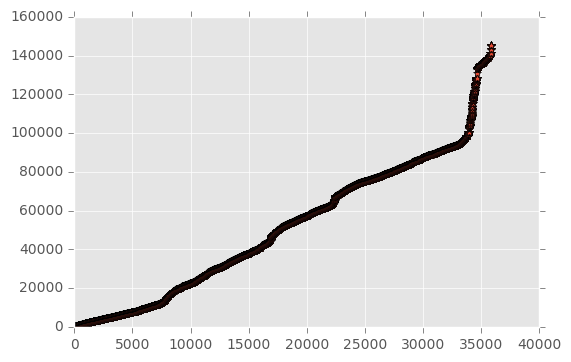

In [27]:
supra_bits = np.where(all_rms > thresh_rms)[0]
plt.plot(np.arange(supra_bits.size), supra_bits, '*')

In [28]:
# Another way of finding the bouts:
# No refractory period for now

from itertools import groupby
from operator import itemgetter
group_bound = np.array([0, 0], dtype=np.int32)

for k, g in groupby(enumerate(supra_bits), lambda (i, x): i-x):
    group = map(itemgetter(1), g)
    if len(group) >= bits_bout:
        group_bound = np.vstack((group_bound, np.array([group[0], group[-1]])) )
        #print group

if group_bound.size > 2:
    found_bouts = True
    group_bound = np.delete(group_bound, 0, axis=0)
    # segments has to be in samples 
    segments = np.array([all_starts[group_bound[:,0]], all_starts[group_bound[:,1]]])
    assert(np.all(np.diff(segments, axis=0)[0]>0))

else:
    found_bouts = False

assert(found_bouts)

In [29]:
group[-1]

145725

In [30]:
#Make a chunk with each segment and record it to a file
more = 2 #how many bits before and after to save
n_seg = segments.shape[1]

print n_seg
# bout_file_name = rec + '_' + str(run).zfill(2) + 'bouts.wav'
# bout_file_path = os.path.join(raw_file_folder, bout_file_name)

# bout_file_path = '/Users/zeke/bout_test2.wav'

import wave
import struct

bouts_out = wave.open(bout_file_path, 'w')
print bout_file_path
bouts_out.setparams((all_sound.n_chans, 2, all_sound.s_f, 0, 'NONE', 'not compressed'))

for seg in segments.T:
    seg = seg + np.array([-more, more])* bit_size_sample

    start = seg[0] if seg[0] > 0 else 0
    end = seg[1] if seg[1] < all_sound.n_samples else all_sound.n_samples
    #print start, end
    sg_chunk = Chunk(all_sound, segment = [start, end])
    # save the chunk to a data file
    #filter for debugging
    #sg_chunk.apply_filter(band_pass_filter, hp_b, hp_a, lp_b, lp_a)
    data_out = np.array(sg_chunk.data, dtype=np.int16)[0]
    packed_data = struct.pack('<' + str((end - start)) + 'h', *data_out)
    bouts_out.writeframes(data_out)

bouts_out.close()

3480
/mnt/cube/earneodo/bci_zf/raw_data/z028/001/a_02_autobouts.wav


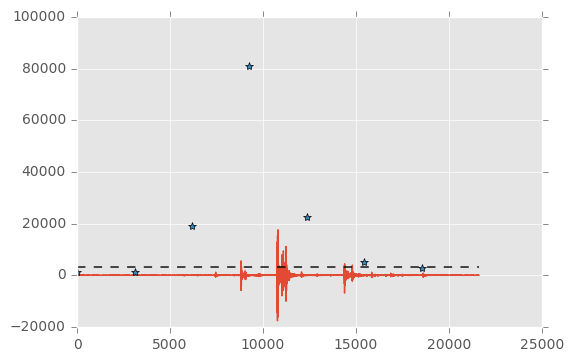

In [31]:
j = 10
chu = Chunk(all_sound, segment=[segments[0, j] - more *bit_size_sample, segments[1, j] + more *bit_size_sample])
chu.apply_filter(band_pass_filter, hp_b, hp_a, lp_b, lp_a)

chu_starts = np.arange(segments[0, j] - more*bit_size_sample, segments[1,j] + more *bit_size_sample, bit_size_sample)
rms_chu = all_sound.apply_repeated(chu_starts, bit_size_sample, rms_band_pass_filter, hp_b, hp_a, lp_b, lp_a)
plt.plot(np.transpose(chu.data))
plt.plot(chu_starts-chu_starts[0], rms_chu, '*')
plt.plot(np.arange(chu.data.size), np.ones_like(np.transpose(chu.data)) * thresh_rms, 'k--' )

#just one bit for visualizing and debugging more
k = more
test_bit = Chunk(all_sound, segment=[segments[0, j] + k* bit_size_sample, segments[0, j] + (k+1)* bit_size_sample])
test_bit.apply_filter(band_pass_filter, hp_b, hp_a, lp_b, lp_a)
#plt.plot(np.transpose(test_bit.data))
rms_test = rms(test_bit.data)